In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import inspect
import time
import pickle
import gym

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

from torchbeast.monobeast import create_env, AtariNet
from torchbeast.resnet_monobeast import ResNet
from torchbeast.core import environment

In [2]:
model_base_path = "../../models"
environments = [
    ("CarnivalNoFrameskip-v4", ["Carnival", "MultiTask", "MultiTaskPopart"]),
    ("AirRaidNoFrameskip-v4", ["AirRaid", "MultiTask", "MultiTaskPopart"]),
    ("DemonAttackNoFrameskip-v4", ["DemonAttack", "MultiTask", "MultiTaskPopart"]),
    ("NameThisGameNoFrameskip-v4", ["NameThisGame", "MultiTask", "MultiTaskPopart"]),
    ("PongNoFrameskip-v4", ["Pong", "MultiTask", "MultiTaskPopart"]),
    ("SpaceInvadersNoFrameskip-v4", ["SpaceInvaders", "MultiTask", "MultiTaskPopart"]),
]

generator = np.random.default_rng(42)
seeds = generator.choice(1000000, size=50, replace=False).tolist()

data = {}
for env_name, models in environments:
    environment_actions = []
    for model_name in models:
        start_time = time.time()
        checkpoint = torch.load(os.path.join(model_base_path, model_name, "model.tar"), map_location="cpu")
        if "baseline.mu" not in checkpoint["model_state_dict"]:
            checkpoint["model_state_dict"]["baseline.mu"] = torch.zeros(1)
            checkpoint["model_state_dict"]["baseline.sigma"] = torch.ones(1)
            num_tasks = 1
        else:
            num_tasks = checkpoint["model_state_dict"]["baseline.mu"].shape[0]
        num_actions = checkpoint["model_state_dict"]["policy.weight"].shape[0]

        model = ResNet(observation_shape=None,
                            num_actions=num_actions,
                            num_tasks=num_tasks,
                            use_lstm=False,
                            use_popart=True,
                            reward_clipping="abs_one")
        model.eval()
        model.load_state_dict(checkpoint["model_state_dict"])
            
        actions = []
        for random_seed in seeds:
            gym_env = create_env(env_name)
            gym_env.seed(random_seed)
            env = environment.Environment(gym_env)

            observation = env.initial()
            game_actions = []
            done = False
            with torch.no_grad():
                while not done:
                    agent_outputs, state = model(observation)
                    action = agent_outputs["action"]
                    game_actions.append(action.item())
                    observation = env.step(action)
                    done = observation["done"]
                
            actions.append(game_actions)
            
        environment_actions.append(actions)
        print(f"{env_name}, {model_name} done in {(time.time() - start_time) / 60:.1f} minutes")
            
    data[env_name] = {
        "singletask": environment_actions[0], 
        "multitask": environment_actions[1], 
        "multitaskpopart": environment_actions[2]
    }

pickle.dump(data, open( "50_games_actions.pkl", "wb" ) )

CarnivalNoFrameskip-v4, Carnival done in 1.7 minutes
CarnivalNoFrameskip-v4, MultiTask done in 1.8 minutes
CarnivalNoFrameskip-v4, MultiTaskPopart done in 2.0 minutes
AirRaidNoFrameskip-v4, AirRaid done in 11.2 minutes
AirRaidNoFrameskip-v4, MultiTask done in 10.5 minutes
AirRaidNoFrameskip-v4, MultiTaskPopart done in 8.9 minutes
DemonAttackNoFrameskip-v4, DemonAttack done in 19.0 minutes
DemonAttackNoFrameskip-v4, MultiTask done in 14.9 minutes
DemonAttackNoFrameskip-v4, MultiTaskPopart done in 16.2 minutes
NameThisGameNoFrameskip-v4, NameThisGame done in 12.7 minutes
NameThisGameNoFrameskip-v4, MultiTask done in 4.8 minutes
NameThisGameNoFrameskip-v4, MultiTaskPopart done in 10.3 minutes
PongNoFrameskip-v4, Pong done in 8.7 minutes
PongNoFrameskip-v4, MultiTask done in 10.1 minutes
PongNoFrameskip-v4, MultiTaskPopart done in 10.6 minutes
SpaceInvadersNoFrameskip-v4, SpaceInvaders done in 9.5 minutes
SpaceInvadersNoFrameskip-v4, MultiTask done in 7.3 minutes
SpaceInvadersNoFrameskip-v

In [12]:
def mean_and_std_data(data, env_actions):
    new_data = {}
    for env in data:
        agent_actions = data[env]
        new_data[env] = {}
        current_action_space = env_actions[env]
        for agent in agent_actions:
            actions = agent_actions[agent]
            new_data[env][agent] = {}
            percentages = []
            for game_actions in actions:
                game_actions = np.array(game_actions)
                counts = []
                for _, indices in current_action_space:
                    s = 0
                    for index in indices:
                        s += (game_actions == index).sum()
                    counts.append(s)
                percentages.append([c / game_actions.shape[0] * 100 for c in counts])
                
            percentages = np.array(percentages)
            new_data[env][agent]["mean"] = np.mean(percentages, axis=0)
            new_data[env][agent]["std"] = np.std(percentages, axis=0)
    
    return new_data

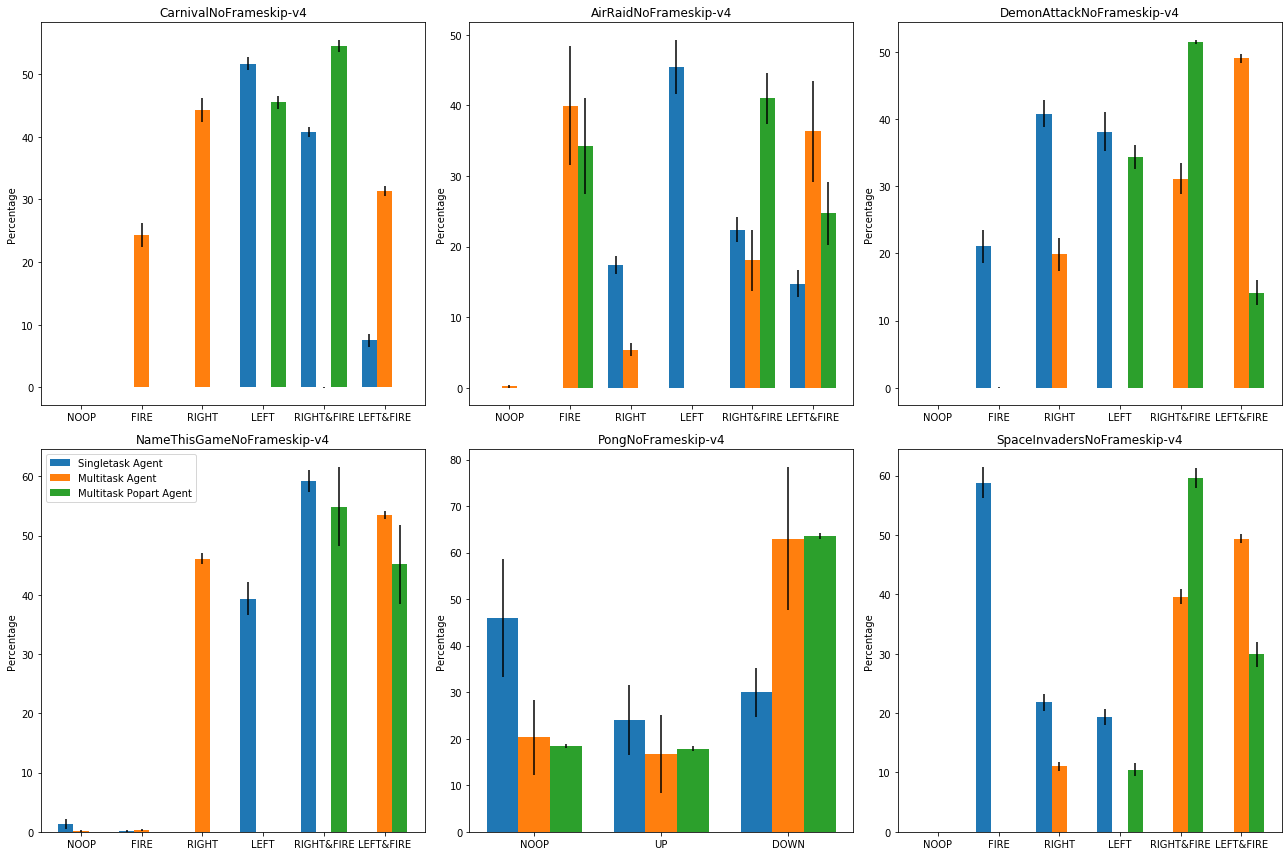

In [29]:
data = pickle.load(open( "50_games_actions.pkl", "rb" ) )
env_actions = {
    "CarnivalNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1]), ("RIGHT", [2]), ("LEFT", [3]), ("RIGHT&FIRE", [4]), ("LEFT&FIRE", [5]) ],
    "AirRaidNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1]), ("RIGHT", [2]), ("LEFT", [3]), ("RIGHT&FIRE", [4]), ("LEFT&FIRE", [5]) ],
    "DemonAttackNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1]), ("RIGHT", [2]), ("LEFT", [3]), ("RIGHT&FIRE", [4]), ("LEFT&FIRE", [5]) ],
    "NameThisGameNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1]), ("RIGHT", [2]), ("LEFT", [3]), ("RIGHT&FIRE", [4]), ("LEFT&FIRE", [5]) ],
    "PongNoFrameskip-v4": [("NOOP", [0, 1]), ("UP", [2, 4]), ("DOWN", [3,5]) ],
    "SpaceInvadersNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1]), ("RIGHT", [2]), ("LEFT", [3]), ("RIGHT&FIRE", [4]), ("LEFT&FIRE", [5]) ],
}

data = mean_and_std_data(data, env_actions)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, env in enumerate(data):
    env_data = data[env]
    width = 0.25
    current_action_space = env_actions[env]
    x = np.arange(len(current_action_space))
    
    axs[i//3, i%3].bar(x - width, env_data["singletask"]["mean"], width, label="Singletask Agent", yerr=env_data["singletask"]["std"])
    axs[i//3, i%3].bar(x, env_data["multitask"]["mean"], width, label="Multitask Agent", yerr=env_data["multitask"]["std"])
    axs[i//3, i%3].bar(x + width, env_data["multitaskpopart"]["mean"], width, label="Multitask Popart Agent", yerr=env_data["multitaskpopart"]["std"])
    
    axs[i//3, i%3].set_xticks(x)
    axs[i//3, i%3].set_xticklabels([action_meaning for action_meaning,_ in current_action_space])
    axs[i//3, i%3].set_ylabel('Percentage')
    axs[i//3, i%3].set_title(env)
    if i//3 == 1 and i%3 == 0:
        axs[i//3, i%3].legend()

fig.tight_layout()
plt.savefig("action_distributions_all_actions.png")

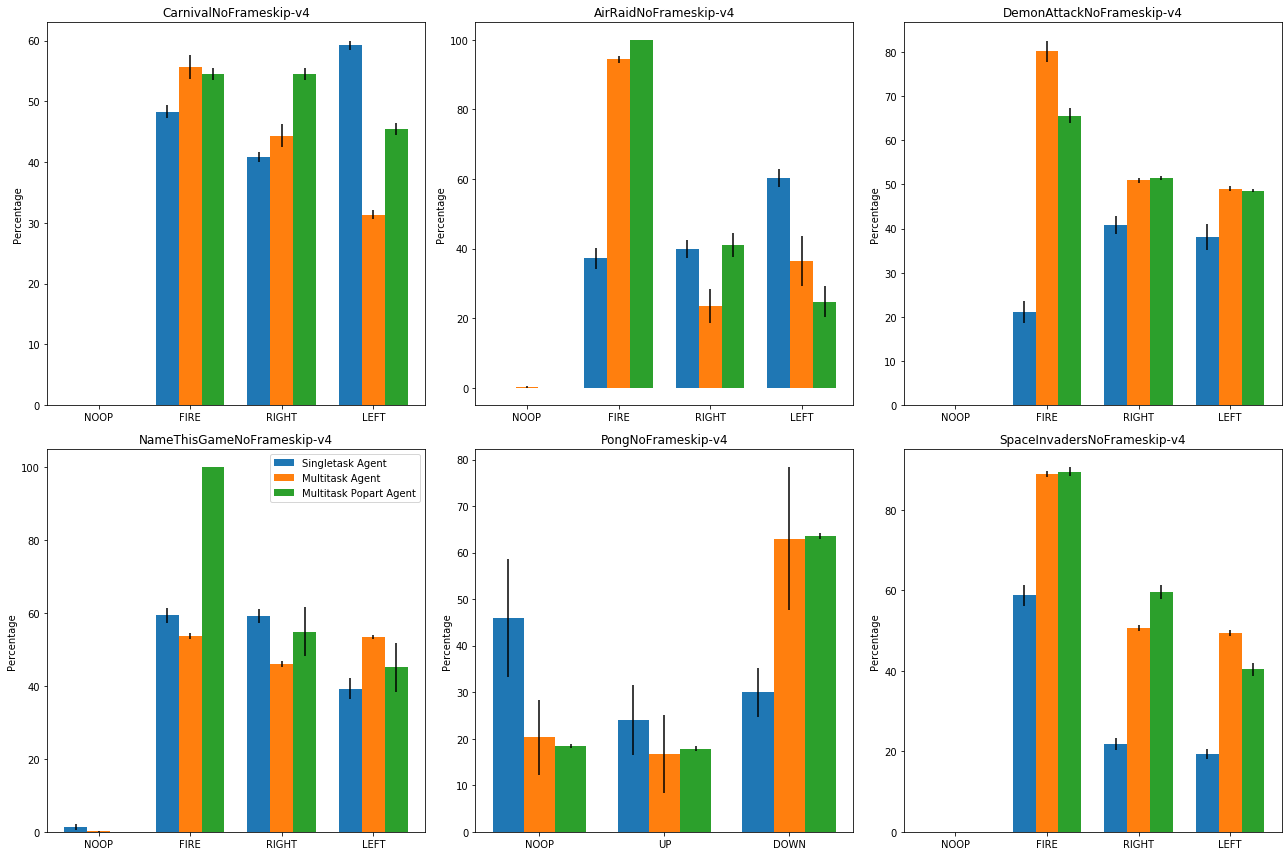

In [30]:
data = pickle.load(open( "50_games_actions.pkl", "rb" ) )
env_actions = {
    "CarnivalNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1,4,5]), ("RIGHT", [2,4]), ("LEFT", [3,5]) ],
    "AirRaidNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1,4,5]), ("RIGHT", [2,4]), ("LEFT", [3,5]) ],
    "DemonAttackNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1,4,5]), ("RIGHT", [2,4]), ("LEFT", [3,5]) ],
    "NameThisGameNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1,4,5]), ("RIGHT", [2,4]), ("LEFT", [3,5]) ],
    "PongNoFrameskip-v4": [("NOOP", [0, 1]), ("UP", [2, 4]), ("DOWN", [3,5]) ],
    "SpaceInvadersNoFrameskip-v4": [("NOOP", [0]), ("FIRE", [1,4,5]), ("RIGHT", [2,4]), ("LEFT", [3,5]) ],
}

data = mean_and_std_data(data, env_actions)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, env in enumerate(data):
    env_data = data[env]
    width = 0.25
    current_action_space = env_actions[env]
    x = np.arange(len(current_action_space))
    
    axs[i//3, i%3].bar(x - width, env_data["singletask"]["mean"], width, label="Singletask Agent", yerr=env_data["singletask"]["std"])
    axs[i//3, i%3].bar(x, env_data["multitask"]["mean"], width, label="Multitask Agent", yerr=env_data["multitask"]["std"])
    axs[i//3, i%3].bar(x + width, env_data["multitaskpopart"]["mean"], width, label="Multitask Popart Agent", yerr=env_data["multitaskpopart"]["std"])
    
    axs[i//3, i%3].set_xticks(x)
    axs[i//3, i%3].set_xticklabels([action_meaning for action_meaning,_ in current_action_space])
    axs[i//3, i%3].set_ylabel('Percentage')
    axs[i//3, i%3].set_title(env)
    if i//3 == 1 and i%3 == 0:
        axs[i//3, i%3].legend()

fig.tight_layout()
plt.savefig("action_distributions_aggregated_actions.png")